# Summary

In this notebook we use the implementation of ConvNext/U-Transformer. This combination uses both the features of the ConvNext model as well as the MHSA and MHCA to build out a 

## TODO
1. lots

# Imports/Setup

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook
from diffusers import UNet2DModel
import data
import dataset
import model
import utility
import training
import distributed
import math
import utility
import op_train
from torch import nn
from safetensors.torch import load_file
import matplotlib.animation as animation

## Configuration

...

In [35]:
class Config:
    # dataset
    path = '/data/users/jupyter-dam724/colliding_solutions'
    solver = 'ros2'
    fixed_seq_len = 216
    ahead = 1
    tail = 1
    upsample_size = 96
    
    total_batch_size = 2
    tworkers = 6
    vworkers = 6
    aug = None
    
    # device
    device_pref = 'cuda'
    device_ind = 3
    
    # model
    epoches = 20
    patience = 5
    lr = 1e-6
    save_path = '/data/users/jupyter-dam724/operator-learning/checkpoint/t'
    timesteps = 4000
    experiment_name = 'operator-training-adjusted-dropoutbigger'
    tset = 'valid'
    from_checkpoint = f'/data/users/jupyter-dam724/time-invariant-operator/checkpoint/{experiment_name}/{tset}/model.safetensors'

# Dataset

...

In [36]:
data_params = {
    'path': Config.path, 
    'device_pref': Config.device_pref, 
    'solver': Config.solver, 
    'fixed_seq_len': Config.fixed_seq_len, 
    'ahead': Config.ahead, 
    'tail': Config.tail,
    'device_ind': Config.device_ind
}

device, (x_train_data, y_train_data), (x_valid_data, y_valid_data) = data.main(**data_params)

dataset_params = {
    'x_train_data': x_train_data, 
    'y_train_data': y_train_data, 
    'x_valid_data': x_valid_data, 
    'y_valid_data': y_valid_data, 
    'batch_size': Config.total_batch_size,
    'tworkers': Config.tworkers, 
    'vworkers': Config.vworkers,
    'upsample_size': Config.upsample_size,
    'aug': Config.aug
}

train_dl, valid_dl = dataset.main_operator(**dataset_params)

Now using GPU.
Train size: 145097, Percent of toal: 74.68%, Unique instances: 700
Train size: 49194, Percent of toal: 25.32%, Unique instances: 240


# Model

...

In [37]:
def count_parameters(model):
    table = []
    total_params = 0
    
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        param = parameter.numel()
        table.append([name, param])
        total_params += param
    
    print(f"Total trainable parameters: {total_params:,}")

In [38]:
unet = UNet2DModel(
    sample_size=(Config.upsample_size, Config.upsample_size),        
    in_channels=1,         
    out_channels=1,         
    layers_per_block=2,      
    block_out_channels=(64, 64, 128, 64),  
    down_block_types=(
        "DownBlock2D",      # 64 channels at 96x96
        "DownBlock2D",      # 64 channels at 48x48
        "AttnDownBlock2D",  # 128 channels at 24x24
        "AttnDownBlock2D"   # 64 channels at 12x12
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
    ),
    dropout=0.5
).to(device)

In [39]:
count_parameters(unet)

Total trainable parameters: 4,988,033


In [40]:
if Config.from_checkpoint is not None:
    state_dict = load_file(Config.from_checkpoint)
    model.load_model_weights(unet, state_dict)

## Evaluation

...

In [41]:
x, y, t = next(iter(valid_dl))

In [42]:
unet.eval()
with torch.no_grad():
    out = unet(x.to(device), torch.ones(Config.total_batch_size).to(device))[0]
    if x.shape[0] != 1:
        x_out = torch.concatenate([x[:, 1:].to(device), out], dim=1)
    else:
        x_out = out
    
    for _ in range(100):
        out = unet(x_out, 1*torch.ones(Config.total_batch_size).to(device))[0]
        if x.shape[0] != 1:
            x_out = torch.concatenate([x_out[:, 1:].to(device), out], dim=1)
        else:
            x_out = out

In [43]:
import torch.nn.functional as F

ind = 1

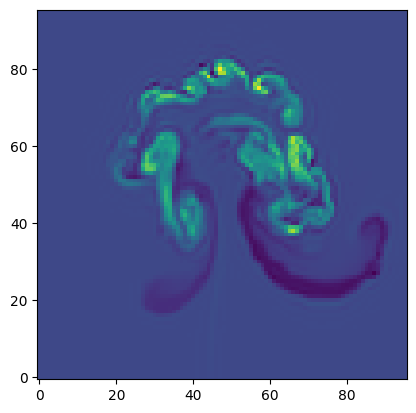

In [44]:
plt.imshow(x[ind][0].cpu(), origin='lower');

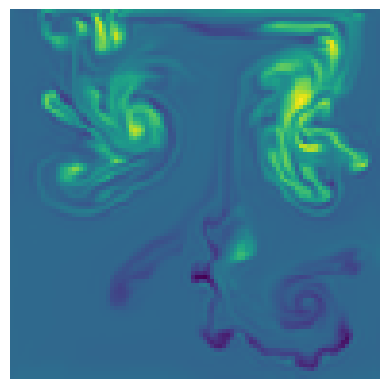

In [45]:
if False:
    img_tensor = out[ind][0].unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, H, W]

    upsampled_img = F.interpolate(img_tensor, size=(224, 224), mode='bilinear', align_corners=False)
    upsampled_img = upsampled_img.squeeze()

    plt.imshow(upsampled_img.cpu(), origin='lower')
else:
    plt.imshow(out[ind][0].cpu(), origin='lower')
    
plt.axis('off');

# Advance Time

Step through time and see output.

In [46]:
pred, ground = [], []

In [47]:
def indepent_channel_select(x_vec, channels=[3], seq_len=1):  
    tensor = torch.zeros((len(channels)*seq_len,) + x_vec.shape[1:])
    
    for ind in range(x_vec.shape[0] // 4):
        base_idx = ind * 4
        for idx, ch in enumerate(channels):
            if ch == 1:
                tensor[idx+ind*len(channels)] = x_vec[base_idx+1] / x_vec[base_idx]
            if ch == 2:
                tensor[idx+ind*len(channels)] = x_vec[base_idx+2] / x_vec[base_idx]
            if ch == 3:
                tensor[idx+ind*len(channels)] = x_vec[base_idx+3] / x_vec[base_idx]
    
    return tensor

def load_instances(data_instance, upsample_size=96, dtype=torch.float32, channels=4, seq_len=1, channel_select=[3]):
    np_instances = np.zeros((1, channels*10000))
    
    np_instances[0, :] = np.load(data_instance)
    
    torch_instances = torch.from_numpy(np_instances).to(dtype=dtype)
    
    if upsample_size is not None:
        inpt = nn.functional.interpolate(torch_instances.view(1, seq_len*channels, 100, 100), size=(upsample_size, upsample_size), mode='bicubic')
        return indepent_channel_select(inpt.view(channels*seq_len, upsample_size, upsample_size), seq_len=seq_len, channels=channel_select)
    
    return indepent_channel_select(inpt.view(channels*seq_len, 100, 100), seq_len=seq_len, channels=channel_select)  

def preprocess(input_tensor, target_tensor):
    # Compute mean and std for each image in the batch
    # keepdim=True maintains the dimension for broadcasting
    in_means = torch.mean(input_tensor, dim=(1, 2), keepdim=True)
    in_stds = torch.std(input_tensor, dim=(1, 2), keepdim=True)
    
    tar_means = torch.mean(target_tensor, dim=(1, 2), keepdim=True)
    tar_stds = torch.std(target_tensor, dim=(1, 2), keepdim=True)
    
    # Add small epsilon to avoid division by zero
    eps = 1e-8
    
    # Apply standardization: (x - mean) / std
    standard_input = (input_tensor - in_means) / (in_stds + eps)
    standard_target = (target_tensor - tar_means) / (tar_stds + eps)
    
    return standard_input, standard_target

In [48]:
for i in range(0, 211):
    if i % 1 == 0:
        inpt, _ = preprocess(load_instances(x_valid_data[i][0]), load_instances(y_valid_data[i][0]))
        ground.append(inpt[0])

In [16]:
# inputs, _ = preprocess(load_instances('/data/users/jupyter-dam724/base/ros2_x_0_0.npy'), load_instances('/data/users/jupyter-dam724/base/ros2_x_0_0.npy'))

In [49]:
if Config.ahead != 1:
    inputs_1, _ = preprocess(load_instances(x_valid_data[0][0]), load_instances(y_valid_data[0][0]))
    inputs_2, _ = preprocess(load_instances(x_valid_data[1][0]), load_instances(y_valid_data[1][0]))
    inputs_3, _ = preprocess(load_instances(x_valid_data[2][0]), load_instances(y_valid_data[2][0]))

    pred.append(inputs_1[0])
    pred.append(inputs_2[0])
    pred.append(inputs_3[0])
else:
    inputs, _ = preprocess(load_instances(x_valid_data[0][0]), load_instances(y_valid_data[0][0]))
    pred.append(inputs[0])

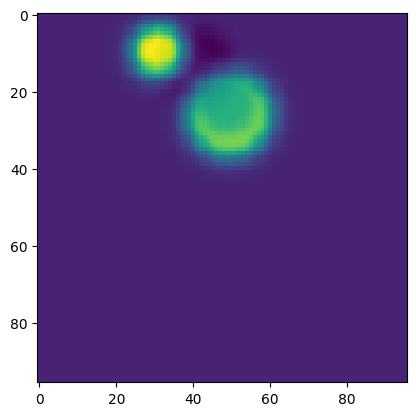

In [50]:
plt.imshow(pred[0]);

In [51]:
def pre_step(out):
    out = torch.clamp(out, min=-1, max=7)
    
    mu = out.mean()
    std = out.std()
    eps = 1e-8
    
    return (out - mu) / (std + eps)

In [52]:
unet.eval()
with torch.no_grad():
    x = torch.from_numpy(np.array(pred)).unsqueeze(0).repeat(2, 1, 1, 1)
    out = unet(x.to(device), 1*torch.ones(Config.total_batch_size).to(device))[0]
    out = pre_step(out)
    if Config.ahead != 1:
        x_out = torch.concatenate([x[:, 1:].to(device), out], dim=1)
    else:
        x_out = out
    pred.append(out[0][0].cpu())
    
    for _ in range(len(ground)-2):
        out = unet(x_out, 1*torch.ones(Config.total_batch_size).to(device))[0]
        out = pre_step(out)
        if Config.ahead != 1:
            x_out = torch.concatenate([x_out[:, 1:].to(device), out], dim=1)
        else:
            x_out = out
        pred.append(out[0][0].cpu())

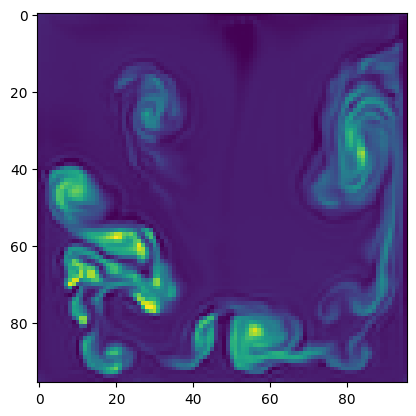

In [53]:
plt.imshow(pred[-1]);

## Seqeuence Evaluation

See how the model is doing.

In [54]:
def seq_animation(sequence, title, ground_len=None):
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    
    ax.axis('off')
    
    x_0_ind = sequence[0]
        
    a = ax.imshow(x_0_ind, origin='lower')
    fig.colorbar(a, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    
    def update_frame(i):
        ax.clear()
                
        x_ind = sequence[i]
        
        a = ax.imshow(x_ind, origin='lower')
    
        return [a]

    ani = animation.FuncAnimation(fig, update_frame, frames=len(ground) if ground_len is None else ground_len, interval=1, blit=True)
    
    print(f'Generating animation.')

    output_path = f'{title}.gif'
    ani.save(output_path, writer='Pillow', fps=20)

MovieWriter Pillow unavailable; using Pillow instead.


Generating animation.


MovieWriter Pillow unavailable; using Pillow instead.


Generating animation.


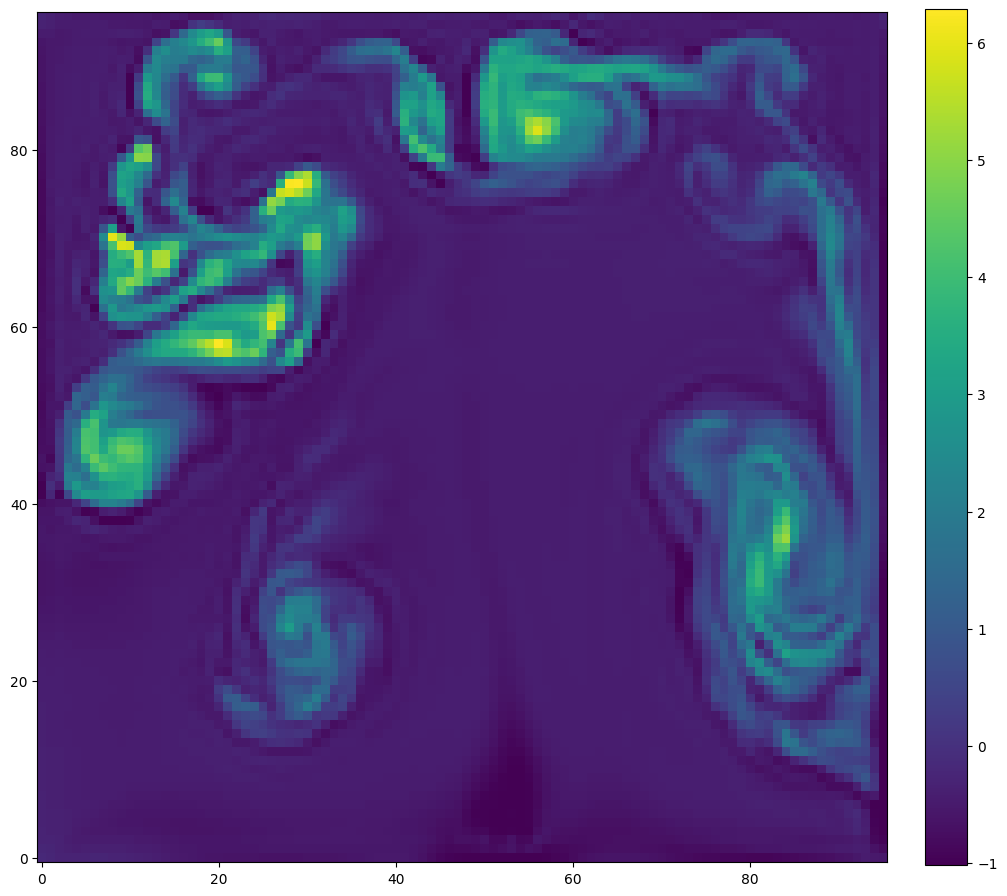

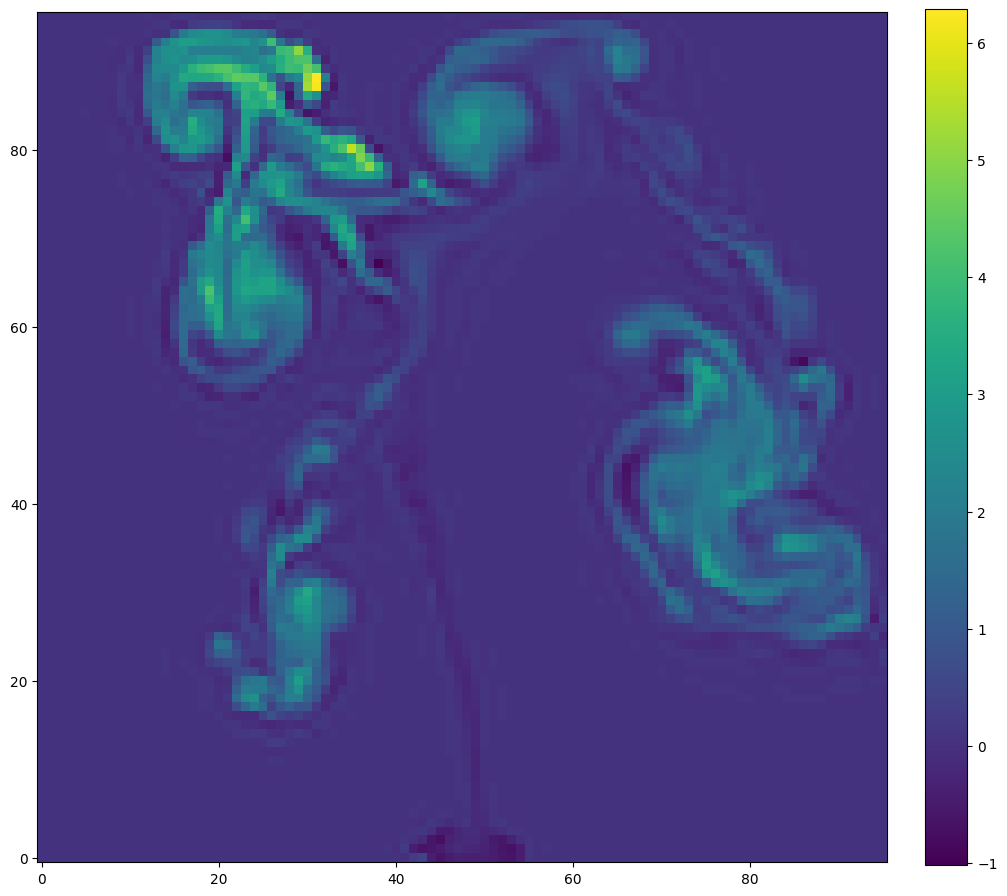

In [55]:
seq_animation(pred, 'operator');
seq_animation(ground, 'ground');